In [19]:
import pandas as pd
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Features table

In [3]:
data = pd.read_csv('dataintermediate.csv')

In [4]:
Features = data[['stories', 'fireplace', 'sqft', 'PrivatePool',
                 'Year built', 'Remodeled year', 'baths/bed',
                 'Parking', 'school_rating', 'density', 'status', 'propertyType']]
target = data.Price

In [5]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212437 entries, 0 to 212436
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stories         212437 non-null  int64  
 1   fireplace       212437 non-null  int64  
 2   sqft            212437 non-null  float64
 3   PrivatePool     212437 non-null  int64  
 4   Year built      212437 non-null  int64  
 5   Remodeled year  212437 non-null  int64  
 6   baths/bed       212437 non-null  float64
 7   Parking         212437 non-null  int64  
 8   school_rating   212437 non-null  int64  
 9   density         212437 non-null  float64
 10  status          212437 non-null  int64  
 11  propertyType    212437 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 19.4 MB


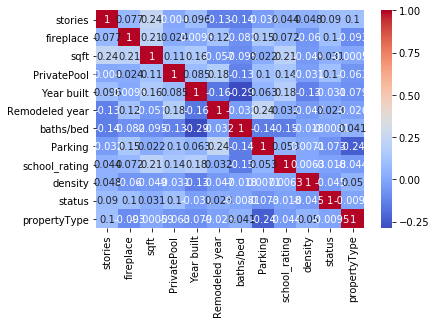

In [15]:
sns.heatmap(Features.corr(), annot=True, cmap='coolwarm')
#most of the variables have low correlation

Text(0.5, 0, 'Relative Importance')

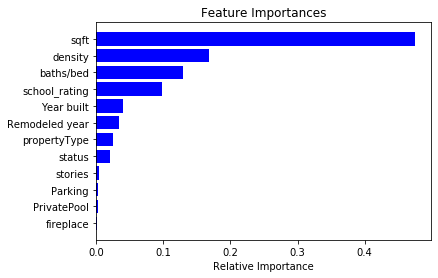

In [20]:
RFR = RandomForestRegressor(max_depth = 10)
features=Features.columns[[0,1,2,3,4,5,6,7,8,9,10,11]]
RFR.fit(Features, target)
importances = RFR.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [21]:
Features = data[['sqft', 'Year built', 'baths/bed', 'school_rating', 'density']]

# Model

In [22]:
scaler = StandardScaler()
FeaturesSt = scaler.fit_transform(Features)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(FeaturesSt, target, random_state=42, test_size=0.2)
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (169949, 5)
X_test: (42488, 5)
y_train: (169949,)
y_test: (42488,)


In [24]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the regressor.
    
    :arg regr: scikit-learn regressor
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_r = clone(regr)
        folded_r.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_r.predict(X_fold_predict)
    
    meta_r = clone(regr)
    meta_r.fit(X_train, y_train)
    
    X_meta_test = meta_r.predict(X_test)
    
    return X_meta_train, X_meta_test

In [25]:
def generate_metafeatures(regrs, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of regressors.
    
    :arg regrs: list of scikit-learn regressors
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv)
        for regr in tqdm(regrs)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [26]:
LR =  LinearRegression()
DTR = DecisionTreeRegressor(max_depth=10, criterion='mae', random_state=42)
RFR = RandomForestRegressor(max_depth=20, random_state=42)
ABR = AdaBoostRegressor(LR, n_estimators=500, learning_rate=0.8)

In [27]:
#Parameters for LR
distributions={
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'n_jobs': [-1, 5, None]
}
LRP = RandomizedSearchCV(LR, distributions, random_state=0)
search = LRP.fit(X_train, y_train)
search.best_params_

{'normalize': True, 'n_jobs': None, 'fit_intercept': True}

In [28]:
LRnew =  LinearRegression(normalize=True, fit_intercept=True)

In [29]:
#Parameters for DecisionTreeRegressor(DTR)
distributions={
    'max_depth': [3, 7, 9, 17, 30, None],
    'criterion': ['mse', 'friedman_mse'],
    'random_state': [0, 42],
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 5],
    'max_features': ['auto', 'sqrt', None]
}
r = RandomizedSearchCV(DTR, distributions, random_state=0)
search = r.fit(X_train, y_train)
search.best_params_

{'random_state': 42,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 30,
 'criterion': 'mse'}

In [30]:
DTRnew = DecisionTreeRegressor(max_depth=30, criterion='mse', random_state=0, min_samples_split=7,
                              min_samples_leaf=5, max_features='auto')

In [31]:
#Parameters for RandomForestRegressor(RFR)
distributions={
    'n_estimators': [30, 50, 100, 120],
    'criterion': ['mse', 'friedman_mse'],
    'max_depth': [5, 10, 15, None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'n_jobs': [-1, 10],
    'random_state': [0, 10, 42]
}
r = RandomizedSearchCV(RFR, distributions, random_state=0)
search = r.fit(X_train, y_train)
DTRnewpar = search.best_params_

C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py"

C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 351, in fit
    raise ValueError("Out of bag estimation only available"
ValueError: Out of bag estimation only available if bootstrap=True

  FitFailedWarning)
C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\dom\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py"

In [32]:
RFRnew = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1, n_estimators=100,
                           max_depth=15, criterion='mse', bootstrap=True)

In [33]:
#Parameters for AdaBoostRegressor(ABR)
distributions={
    'base_estimator': [LinearRegression(), None],
    'n_estimators': [10, 50],
    'learning_rate': [0.8, 0.75],
    'loss': ['linear', 'square', 'exponential'],
    'random_state': [0, 42]
}
r = RandomizedSearchCV(ABR, distributions, random_state=0)
search = r.fit(X_train, y_train)
search.best_params_

{'random_state': 0,
 'n_estimators': 10,
 'loss': 'exponential',
 'learning_rate': 0.8,
 'base_estimator': None}

In [34]:
ABRnew = AdaBoostRegressor(base_estimator=None, n_estimators=10, learning_rate=0.8, loss='exponential', random_state=0)

In [35]:
total_features_train = np.hstack([X_train, stacked_features_train])
total_features_test = np.hstack([X_test, stacked_features_test])

NameError: name 'stacked_features_train' is not defined

In [ ]:
GBR = GradientBoostingRegressor()
predictor = GBR
predictor.fit(stacked_features_train, y_train)
y_pred = predictor.predict(stacked_features_test)

In [ ]:
mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
print(f'R^2 GB: {round(predictor.score(stacked_features_test,y_test),4)}, MAE GB: {round(mae,2)}, RSME: {round(np.sqrt(mse),2)}')

![title](fin.jpg)

During my work the score has inceased from 0.1 at the beginning to what I have now. This is not the best score and probably additional work is required for data and ML.

    add more features like the distance from center based on street and additional data of central street in each city, heating, cooling
    optimize the model: find the best parameters to reduce time, find the best steking set
    increase the NA treatments
    increase exceptions treatment
    code refactoring and style improvement
    Prepare the models to Production
    Improve code style according to pep8

Is scheduled for the next sprint :)
